*Eduardus Tjitrahardja | @edutjie | 2022*

# Final Assessment: AI/ML Challenge - Predicting Sarcastic Headlines

## Importing Libraries

In [30]:
import pandas as pd
import numpy as np
import spacy, re, nltk, contractions, string, textblob
pd.set_option('display.max_columns', 200)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
plt.style.use("seaborn")

## Loading Dataset

### Load Train Dataset

In [3]:
train_df = pd.read_csv('data/Train_Data.csv')
train_df.head()

,headline,is_sarcastic
0,supreme court votes 7-2 to legalize all worldl...,1
1,hungover man horrified to learn he made dozens...,1
2,emily's list founder: women are the 'problem s...,0
3,send your kids back to school with confidence,0
4,watch: experts talk pesticides and health,0


In [4]:
print("Train Dataset shape:", train_df.shape)
train_df.info()

Train Dataset shape: (44262, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44262 entries, 0 to 44261
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      44262 non-null  object
 1   is_sarcastic  44262 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 691.7+ KB


### Load Test Dataset

In [5]:
test_df = pd.read_csv('data/Test_Data.csv')
test_df.head()

,headline
0,area stand-up comedian questions the deal with...
1,dozens of glowing exit signs mercilessly taunt...
2,perfect response to heckler somewhere in prop ...
3,gop prays for ossoff lossoff
4,trevor noah says the scary truth about trump's...


In [6]:
print("Test Dataset shape:", test_df.shape)
test_df.info()

Test Dataset shape: (11066, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11066 entries, 0 to 11065
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  11066 non-null  object
dtypes: object(1)
memory usage: 86.6+ KB


## Data Preprocessing

### Check Duplicate Rows

In [7]:
# check duplicated rows
train_df.duplicated().sum()

17204

In [8]:
# drop duplicated rows
train_df.drop_duplicates(inplace=True)
train_df.shape

(27058, 2)

In [9]:
# check duplicated rows again
train_df.duplicated().sum()

0

### Check Missing Values

In [10]:
train_df.isnull().sum()

headline        0
is_sarcastic    0
dtype: int64

### Check How Balance is the Train Dataset

In [11]:
train_df.is_sarcastic.value_counts()

0    14358
1    12700
Name: is_sarcastic, dtype: int64

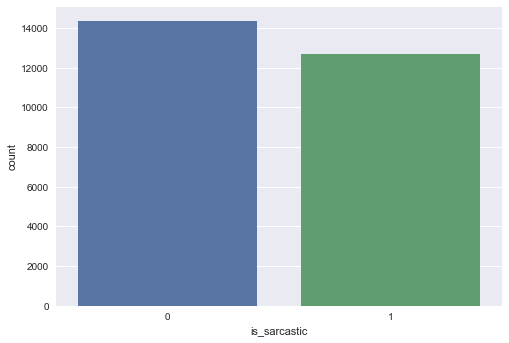

In [12]:
sns.countplot(x='is_sarcastic', data=train_df)
plt.show()

The target column is quite balanced

## Split X and y

In [13]:
X = pd.concat([train_df[['headline']], test_df], ignore_index=True)
y = train_df.is_sarcastic

X.shape, y.shape

((38124, 1), (27058,))

## Feature Engineering

### Basic NLP Count based Features

In [14]:
X["char_count"] = X["headline"].apply(len)
X["word_count"] = X["headline"].apply(lambda x: len(x.split()))
X["word_density"] = X["char_count"] / (X["word_count"] + 1)
X["punctuation_count"] = X["headline"].apply(
    lambda x: len("".join(_ for _ in x if _ in string.punctuation))
)
X.head()

,headline,char_count,word_count,word_density,punctuation_count
0,supreme court votes 7-2 to legalize all worldl...,53,9,5.300000,1
1,hungover man horrified to learn he made dozens...,66,12,5.076923,0
2,emily's list founder: women are the 'problem s...,65,10,5.909091,4
3,send your kids back to school with confidence,45,8,5.000000,0
4,watch: experts talk pesticides and health,41,6,5.857143,1


### Sentiment Analysis

In [15]:
X_sentiment_obj = X.headline.apply(lambda x: textblob.TextBlob(x).sentiment)
X_sentiment_obj

0                                       (0.0, 0.0)
1                       (0.0, 0.06666666666666667)
2                                       (0.0, 0.0)
3                                       (0.0, 0.0)
4                                       (0.0, 0.0)
                           ...                    
38119    (-0.3333333333333333, 0.3666666666666667)
38120                             (-0.14375, 0.45)
38121                                   (0.0, 0.0)
38122                                   (0.0, 0.0)
38123                                   (0.0, 0.0)
Name: headline, Length: 38124, dtype: object

In [16]:
X['polarity'] = X_sentiment_obj.apply(lambda x: x.polarity)
X['subjectivity'] = X_sentiment_obj.apply(lambda x: x.subjectivity)
X.head()

,headline,char_count,word_count,word_density,punctuation_count,polarity,subjectivity
0,supreme court votes 7-2 to legalize all worldl...,53,9,5.300000,1,0.0,0.000000
1,hungover man horrified to learn he made dozens...,66,12,5.076923,0,0.0,0.066667
2,emily's list founder: women are the 'problem s...,65,10,5.909091,4,0.0,0.000000
3,send your kids back to school with confidence,45,8,5.000000,0,0.0,0.000000
4,watch: experts talk pesticides and health,41,6,5.857143,1,0.0,0.000000


### Text Processing

In [17]:
stop_words = nltk.corpus.stopwords.words('english')

In [18]:
ps =  nltk.stem.PorterStemmer()

def text_processor(doc):
    # fix construction of tokens
    doc = contractions.fix(str(doc).lower())
    
    # remove unnecessary characters
    doc = re.sub(r'[^a-zA-Z]',r' ', doc)
    doc = re.sub(r'nbsp', r'', doc)
    doc = re.sub(' +', ' ', doc)
    
    # stem words
    doc = ' '.join(ps.stem(word) for word in doc.split())
    return ' '.join(word for word in doc.split() if word not in stop_words)

tp = np.vectorize(text_processor)

In [19]:
X['headline'] = tp(X.headline)
X.head()

,headline,char_count,word_count,word_density,punctuation_count,polarity,subjectivity
0,suprem court vote legal worldli vice,53,9,5.300000,1,0.0,0.000000
1,hungov man horrifi learn made dozen plan last ...,66,12,5.076923,0,0.0,0.066667
2,emili list founder women problem solver congress,65,10,5.909091,4,0.0,0.000000
3,send kid back school confid,45,8,5.000000,0,0.0,0.000000
4,watch expert talk pesticid health,41,6,5.857143,1,0.0,0.000000


### Bag of Words based Features - 1-grams

In [20]:
cv = CountVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1, 1))

In [21]:
X_cv = pd.DataFrame(cv.fit_transform(X.headline).toarray(), columns=cv.get_feature_names_out())
X_cv.head()

,aaa,aaron,aarp,aatish,ab,abandon,abaya,abba,abbey,abbi,abc,abdeslam,abdomen,abdomin,abduct,abdul,abe,abedin,abhorr,abid,abil,abject,abl,aboard,abolish,abomin,abort,abov,aboveground,abraham,abram,abramson,abridg,abroad,abruptli,abscond,absenc,absent,absentmind,abso,absolut,absolv,absorb,abstent,abstract,absurd,abu,abukar,abus,abuzz,abysm,abyss,aca,academ,academi,acadia,acceler,accent,accept,access,accessori,accid,accident,acclaim,acclim,accommod,accompani,accomplish,accord,account,accur,accuraci,accus,accusingli,ace,acetaminophen,ach,achiev,achil,acid,acknowledg,aclu,acn,acnefre,acorn,acosta,acoust,acquaint,acquir,acquisit,acquit,acquitt,acr,acronym,across,act,action,activ,activist,actor,...,yoshi,yother,youlookdisgust,young,younger,youngest,yourselv,yousafzai,youssef,youth,youtub,yowl,yuan,yuletid,yup,yutu,zaatari,zac,zach,zachari,zack,zaeefeh,zagat,zagitova,zair,zakaria,zale,zalman,zalmay,zambia,zamboni,zandt,zangief,zani,zanjeer,zapp,zappa,zapper,zappo,zara,zarin,zawahiri,zayn,zbt,zealand,zealot,zebra,zedd,zee,zeev,zehnder,zeke,zell,zellweg,zen,zendaya,zenefit,zenith,zenzing,zero,zest,zestito,zeta,zeu,zhang,zika,zimbabw,zimmerman,zinc,zinfandel,zinger,zink,zinn,zinnia,zion,zionism,zionist,zip,ziplin,zippori,zissu,ziyi,zod,zodiac,zoe,zoetrop,zogbi,zohan,zombi,zone,zoo,zookeep,zooland,zoologist,zoom,zoroastrian,zsa,zucker,zuckerberg,zz
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
X_final = pd.concat([X_cv, X.drop('headline', axis=1)], axis=1)
X_final.head()

,aaa,aaron,aarp,aatish,ab,abandon,abaya,abba,abbey,abbi,abc,abdeslam,abdomen,abdomin,abduct,abdul,abe,abedin,abhorr,abid,abil,abject,abl,aboard,abolish,abomin,abort,abov,aboveground,abraham,abram,abramson,abridg,abroad,abruptli,abscond,absenc,absent,absentmind,abso,absolut,absolv,absorb,abstent,abstract,absurd,abu,abukar,abus,abuzz,abysm,abyss,aca,academ,academi,acadia,acceler,accent,accept,access,accessori,accid,accident,acclaim,acclim,accommod,accompani,accomplish,accord,account,accur,accuraci,accus,accusingli,ace,acetaminophen,ach,achiev,achil,acid,acknowledg,aclu,acn,acnefre,acorn,acosta,acoust,acquaint,acquir,acquisit,acquit,acquitt,acr,acronym,across,act,action,activ,activist,actor,...,yourselv,yousafzai,youssef,youth,youtub,yowl,yuan,yuletid,yup,yutu,zaatari,zac,zach,zachari,zack,zaeefeh,zagat,zagitova,zair,zakaria,zale,zalman,zalmay,zambia,zamboni,zandt,zangief,zani,zanjeer,zapp,zappa,zapper,zappo,zara,zarin,zawahiri,zayn,zbt,zealand,zealot,zebra,zedd,zee,zeev,zehnder,zeke,zell,zellweg,zen,zendaya,zenefit,zenith,zenzing,zero,zest,zestito,zeta,zeu,zhang,zika,zimbabw,zimmerman,zinc,zinfandel,zinger,zink,zinn,zinnia,zion,zionism,zionist,zip,ziplin,zippori,zissu,ziyi,zod,zodiac,zoe,zoetrop,zogbi,zohan,zombi,zone,zoo,zookeep,zooland,zoologist,zoom,zoroastrian,zsa,zucker,zuckerberg,zz,char_count,word_count,word_density,punctuation_count,polarity,subjectivity
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,53,9,5.300000,1,0.0,0.000000
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,66,12,5.076923,0,0.0,0.066667
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,65,10,5.909091,4,0.0,0.000000
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45,8,5.000000,0,0.0,0.000000
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,6,5.857143,1,0.0,0.000000


## Modeling Training Model

In [23]:
X_train_final = X_final[:train_df.shape[0]]
X_test_final = X_final[train_df.shape[0]:]
X_train_final.shape, y.shape, X_test_final.shape

((27058, 17485), (27058,), (11066, 17485))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_train_final, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21646, 17485), (5412, 17485), (21646,), (5412,))

In [26]:
lr = LogisticRegression(C=1, random_state=150, solver='liblinear', max_iter=100, verbose=0)
lr.fit(X_train, y_train)

LogisticRegression(C=1, random_state=150, solver='liblinear')

In [28]:
y_pred = lr.predict(X_test)
y_pred

array([0, 1, 1, ..., 0, 1, 1], dtype=int64)

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      2901
           1       0.83      0.77      0.80      2511

    accuracy                           0.82      5412
   macro avg       0.82      0.82      0.82      5412
weighted avg       0.82      0.82      0.82      5412



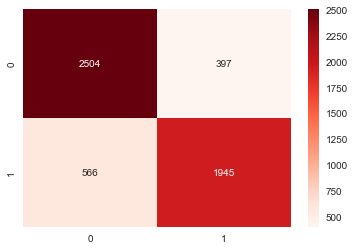

In [36]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Reds')
plt.show()

## Submissionn

In [47]:
predictions = lr.predict(X_test_final)
predictions

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [54]:
submission = pd.DataFrame({'prediction': predictions})
submission.head()

,prediction
0,1
1,1
2,1
3,0
4,0


In [56]:
submission.prediction.to_csv('submissions/submission.csv', index=False)